# BT4222 Content-Based Filtering with ScaNN

## Introduction
This notebook presents the development and evaluation the following model:

- **ScaNN-Based Content Recommender**  
  A content-based model that uses combined movie embeddings and ScaNN (Scalable Nearest Neighbors) for fast similarity search.
- It combines rich content features—such as genres, director, and cast embeddings—into unified movie representations, then leverages ScaNN for fast similarity search.
- The model is tested and evaluated based on how well it recommends similar movies to those a user has previously rated highly.


## Mount Google Drive
This code cell mounts your Google Drive in the Colab environment, enabling access to datasets stored in your drive for subsequent processing.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Libraries and Load Raw Datasets
Importing necessary libraries.
Loading all primary datasets used in the project:

- `df_tmdb_final.csv`: Final movie metadata with embeddings

- `df_links_with_ratings.csv`: User ratings merged with TMDB movie IDs

These datasets are merged to form `df_merged`, a comprehensive dataset that links user preferences to rich movie features.

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import ast

!pip install scann
import scann
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

df_tmdb_final = pd.read_csv("/content/drive/MyDrive/BT4222_Project/df_tmdb_final.csv")
df_links_with_ratings = pd.read_csv("/content/drive/MyDrive/BT4222_Project/df_links_with_ratings.csv")


# Merge df_links_with_ratings and df_tmdb_final
df_merged = pd.merge(df_links_with_ratings, df_tmdb_final, left_on='tmdbId', right_on='movie_id', how='inner')

# Step 1: Prepare Content Feature Dataset
We create a new dataframe df_content by selecting only the columns needed for content-based recommendation:

- `movie_id`: Unique identifier for each movie  
- `original_title`: Movie title  
- `weighted_vote_score`: Popularity/review score used for ranking  
- `genre`: Genre tags (typically as lists or encoded vectors)  
- `director_embedding`: Numeric embedding representing the movie’s director  
- `main_cast_embeddings`: Averaged or stacked embeddings of main cast members  
- `production_company_embedding`: Embedding of the associated production company  
- `original_language_embedding`: Embedding for the movie's original language  

Duplicate entries are removed based on `movie_id` to ensure each movie appears only once in the ScaNN index.

### 1.1 String Cleaning through parse_embedding_from_array_wrapper
When the embeddings were extracted and saved during data cleaning, they were stored as strings in the CSV. These strings sometimes include extra wrappers, such as array( ... ), and have numbers separated by spaces instead of commas—this is not a valid Python literal.

- **Removing Array Wrappers**:
It uses a regular expression to detect and remove the "array(...)" wrapper so that only the inner content remains.

- **Ensuring Proper Bracketing**:
It makes sure that the cleaned string starts with [ and ends with ] so that it represents a valid Python list literal.

- **Inserting Commas**:
It then uses another regular expression to insert commas between numbers that are only separated by whitespace

### 1.2 Defining parse_embedding
When the embeddings were extracted and saved during the data cleaning process, they were converted to strings in the CSV file. This makes it necessary to parse these string representations back into numerical arrays before further processing. The parse_embedding function handles this conversion by:

- **Checking if the input is a string**:
It may be a string representation of a list (e.g., "[0.1, 0.2, 0.3]"), so we need to convert it back to a Python list and then into a NumPy array.

- **Handling errors gracefully**:
If the string cannot be converted (due to formatting issues), the function returns a zero vector with the specified dimension as a fallback.

- **Working with lists or arrays**:
If the embedding is already in list or array format, it converts (or reaffirms) it as a NumPy array.


In [ ]:
#step 1: Preparing the Dataset

# Select relevant content-based features
df_content = df_tmdb_final[[
    'movie_id',
    'original_title',
    'weighted_vote_score',
    'genre',
    'director_embedding',
    'main_cast_embeddings',
    'production_company_embedding',
    'original_language_embedding'
]].drop_duplicates(subset='movie_id').reset_index(drop=True)


def parse_embedding_from_array_wrapper(s, dim=300):
    """
    Convert messy string embeddings (with array(...) wrappers or irregular formatting)
    into fixed-length NumPy vectors.
    """
    if pd.isna(s):
        return np.zeros(dim)

    # Clean wrappers and whitespace
    s = re.sub(r'array\((.*?)\)', r'\1', s)      # Remove 'array(...)'
    s = s.replace('\n', ' ')                     # Remove newlines
    s = s.replace('[', '').replace(']', '')      # Strip brackets

    # Extract floats using regex (handles scientific notation too)
    numbers = re.findall(r'-?\d+\.\d+(?:e[+-]?\d+)?', s)

    try:
        vec = np.array([float(n) for n in numbers], dtype=np.float32)

        # Pad or truncate to target dimension
        if len(vec) < dim:
            vec = np.pad(vec, (0, dim - len(vec)), mode='constant')
        elif len(vec) > dim:
            vec = vec[:dim]

        return vec

    except:
        return np.zeros(dim)


def parse_embedding(x, dim=300):
    """
    Parses an embedding from either a valid string or an actual list/array.
    """
    if isinstance(x, str):
        x = x.strip()
        if x.startswith('[') and x.endswith(']') and 'array' not in x:
            try:
                return np.array(ast.literal_eval(x))
            except:
                return np.zeros(dim)
    elif isinstance(x, (list, np.ndarray)):
        return np.array(x)

    return np.zeros(dim)



embedding_cols = [
    'main_cast_embeddings',
    'director_embedding',
    'production_company_embedding',
    'original_language_embedding',
]

# Apply wrapper-based parsing to messy embedding strings
for col in embedding_cols:
    df_content[col] = df_content[col].apply(lambda v: parse_embedding_from_array_wrapper(v, dim=300))

# Apply standard parsing to clean genre embeddings
df_content['genre'] = df_content['genre'].apply(lambda v: parse_embedding(v, dim=300))
# Build a fast lookup dict: movie_id → index in df_content
movie_id_to_index = {mid: idx for idx, mid in enumerate(df_content['movie_id'])}


In [ ]:
embedding_cols = [
    'main_cast_embeddings',
    'director_embedding',
    'production_company_embedding',
    'original_language_embedding',
    'genre'
]

for col in embedding_cols:
    print(f"{col} — valid (non-zero) vectors:", df_content[col].apply(lambda x: np.sum(x) > 0).sum())

main_cast_embeddings — valid (non-zero) vectors: 268
director_embedding — valid (non-zero) vectors: 1216
production_company_embedding — valid (non-zero) vectors: 1341
original_language_embedding — valid (non-zero) vectors: 1418
genre — valid (non-zero) vectors: 1446


# Step 2: Generate Unified Content Embeddings
### 2.1 Normalization with `l2_normalize(x)`:
Every embedding is converted to a NumPy array and scaled to unit length (L2 normalization). This ensures that regardless of the original vector’s magnitude, all embeddings contribute comparably to the final representation.

### 2.2 Combining Embeddings
Each movie’s content is represented by combining multiple embeddings into a single vector. The combine_embeddings_normalized() function handles this:

- `genre`: Increased to reflect the high importance of genre in influencing audience decisions (1.2)
- `director_embedding`: Down-weighted, as research indicates that the director’s identity has a relatively low impact on initial movie selection (0.7)
- `main_cast_embeddings`: Boosted to capture the substantial influence of movie-star power on audience preferences (1.2)
- `production_company_embedding`: Maintain neutral infleunce
- `original_language_embedding`: Maintain neutral infleunce

The result is a unified `content_embedding` vector stored for each movie. This vector serves as the movie's semantic representation for ScaNN.

In [ ]:
print(type(df_content['main_cast_embeddings'].iloc[0]))
df_content['main_cast_embeddings'].apply(type).value_counts()


<class 'numpy.ndarray'>


,count
main_cast_embeddings,
<class 'numpy.ndarray'>,1446


In [ ]:
# L2 normalization ensures each component contributes proportionally to the final vector based on its direction, not its raw magnitude.
def l2_normalize(x):
    # Ensure x is a NumPy array
    x = np.array(x)
    norm = np.linalg.norm(x)
    # Avoid division by zero
    return x / norm if norm > 0 else x

def combine_embeddings_normalized(row):
    # Process main cast: if the value is a list and non-empty, compute the average; otherwise, use a zero vector
    if isinstance(row['main_cast_embeddings'], list) and len(row['main_cast_embeddings']) > 0:
        main_cast_avg = np.mean(row['main_cast_embeddings'], axis=0)
    else:
        main_cast_avg = np.zeros(300)  # fallback for missing or improperly formatted main cast embeddings
    main_cast_norm = l2_normalize(main_cast_avg)

    # Genre: Expecting a 300-dimensional vector; if missing, use a zero vector, then L2 normalize
    genre = np.array(row['genre']) if isinstance(row['genre'], list) else np.zeros(300)
    genre_norm = l2_normalize(genre)

    # Director: L2 normalize the 300-dimensional director embedding
    director = row['director_embedding'] if isinstance(row['director_embedding'], (list, np.ndarray)) else np.zeros(300)
    director_norm = l2_normalize(director)

    # Production Company: L2 normalize as well
    company = row['production_company_embedding'] if isinstance(row['production_company_embedding'], (list, np.ndarray)) else np.zeros(300)
    company_norm = l2_normalize(company)

    # Original Language: L2 normalize the 300-dimensional language embedding
    language = row['original_language_embedding'] if isinstance(row['original_language_embedding'], (list, np.ndarray)) else np.zeros(300)
    language_norm = l2_normalize(language)

    # Apply the weights based on your domain knowledge:
    # Since all vectors are now 300-dimensional, you don't need an extra scaling factor.
    # Concatenation allows the model (or downstream similarity search like ScaNN) to consider each feature in its own space, while still enabling combined similarity across all dimensions.

    combined = np.concatenate([
        1.2 * genre_norm,         # Genre
        0.7 * director_norm,      # Director
        1.2 * main_cast_norm,     # Main cast
        1.0 * company_norm,       # Production company
        1.0 * language_norm       # Original language
    ])

    return combined

# Apply the updated function to create the content embedding column
df_content['content_embedding'] = df_content.apply(combine_embeddings_normalized, axis=1)
print("Number of Dimensions per Data Point:", df_content['content_embedding'].iloc[0].shape)


Number of Dimensions per Data Point: (1500,)


#Step 3: Dimensionality Reduction with PCA + ScaNN Setup

### 3.1 Identifying Optimal Dimensions
To improve efficiency and search speed in our recommendation system, we first reduce the dimensionality of our unified movie embeddings. The process is as follows:

- **Creating `embedding_matrix`**: We construct an embedding_matrix by stacking all the unified `content_embedding` vectors.
- **Full PCA Fit & Scree Plot Analysis**: We fit PCA on the entire embedding matrix (with original dimensions = 1500) to compute the explained variance for each principal component. Next, we compute the cumulative explained variance ratio and plot it against the number of components. The scree plot helps us visualize how many components are needed to capture a desired levelof the total variance.

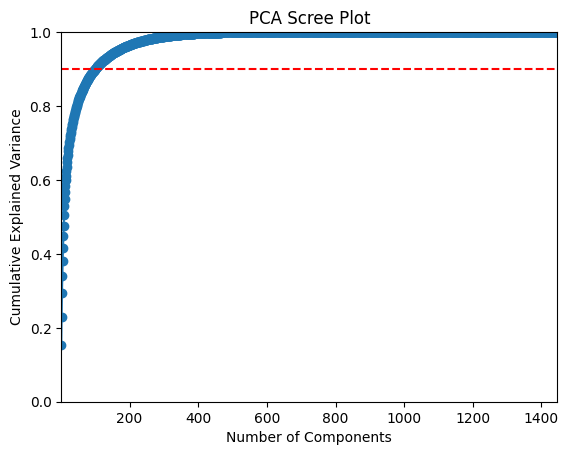

In [ ]:
# Create the embedding matrix
embedding_matrix = np.stack(df_content['content_embedding'].values)

# Fit PCA on the full embedding matrix
pca_full = PCA().fit(embedding_matrix)

# Extract explained variance ratio and compute its cumulative sum
evr = pca_full.explained_variance_ratio_
cumulative_evr = np.cumsum(evr)

# Plot the cumulative explained variance vs. number of components
plt.plot(range(1, len(evr) + 1), cumulative_evr, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.axhline(y=0.90, color='r', linestyle='--')
plt.title("PCA Scree Plot")
plt.xlim([1, len(evr)])
plt.ylim([0, 1])
plt.show()


In [ ]:
threshold = 0.90  # where the elbow is
# cumulative_evr is the cumulative sum of the explained variance ratio
n_components_required = np.argmax(cumulative_evr >= threshold) + 1
print(f"Number of components required to reach {threshold*100}% variance: {n_components_required}")


Number of components required to reach 90.0% variance: 100


### 3.2 PCA Dimensionality Reduction and Scann Build
- **PCA Dimensionality Reduction**: PCA is applied to the embedding matrix to produce a set of `reduced_embeddings` using `n_components_required`
- **L2 Normalization**:
After PCA, the reduced vectors are normalized to unit length using L2 normalization. This removes magnitude differences between vectors and ensures that similarity comparisons are based purely on direction (i.e., cosine similarity), making them more semantically meaningful.
- **Building ScaNN Index**:
ScaNN is then used to build a highly efficient approximate nearest-neighbor index over the normalized embeddings. Instead of brute-force comparison, this setup uses:
  - **Tree-based partitioning** to group similar vectors and limit the search to a subset of them.
  - **Asymmetric hashing (AH)** with anisotropic quantization to accelerate scoring while maintaining precision
  - **Reordering of top 100** candidates to refine similarity scores after initial hashing

In [ ]:
pca = PCA(n_components_required)
reduced_embeddings = pca.fit_transform(embedding_matrix)
# removes magnitude differences between vectors, focus solely on angle, more meaningful comparisons
normalized_embeddings = normalize(reduced_embeddings)
print("Number of Data Points, Number of Dimensions per Data Point:", normalized_embeddings.shape)


searcher = scann.scann_ops_pybind.builder(normalized_embeddings, 1000, "dot_product") \
    .tree(num_leaves=200, num_leaves_to_search=100, training_sample_size=250000) \
    .score_ah(2, anisotropic_quantization_threshold=0.2) \
    .reorder(100) \
    .build()



Number of Data Points, Number of Dimensions per Data Point: (1446, 100)


#Step 4: Define Recommendation Function
We define `recommend_for_user_with_movie()`, which:

####1. Query Embedding Retrieval:
- It locates the index of the input movie (identified by movie_id) in `df_content`.
- Retrieves the corresponding normalized embedding from `normalized_embeddings` to serve as the query.

####2. Similarity Search Using ScaNN:
- The function uses ScaNN to perform a nearest-neighbor search based on the dot-product similarity of embeddings.
- It retrieves a candidate set of similar movies (neighbors).

####3. Filtering & Selection:
- Filters out any movies that the user has already seen (`seen_movie_ids`).
- From the remaining candidates, selects the top‑k most similar items based on embedding similarity.
- Then **re-ranks** the selected items by `weighted_vote_score` in descending order to prioritize quality/popularity.

This approach prioritizes content similarity over other attributes, thus allowing personalized and fresh recommendations for each user.

In [ ]:
# Step 4: Recommendation function using df_final (user ratings)
def recommend_for_user_with_movie(user_id, movie_id, seen_movie_ids, top_k=10, search_k=100):
    try:
        query_idx = movie_id_to_index.get(movie_id, None)
        if query_idx is None:
            return pd.DataFrame()

        query_embedding = normalized_embeddings[query_idx]
        neighbors, distances = searcher.search(query_embedding, final_num_neighbors=search_k)

        recommended = df_content.iloc[neighbors]
        recommended = recommended[~recommended['movie_id'].isin(seen_movie_ids)]

        # Assign similarity scores
        recommended = recommended.assign(similarity=1 - distances[:len(recommended)])

        # Select top_k by similarity first
        top_k_recs = recommended[['original_title', 'movie_id', 'weighted_vote_score', 'similarity']].head(top_k)

        # Re-rank by weighted_vote_score in descending order
        top_k_recs_sorted = top_k_recs.sort_values(by='weighted_vote_score', ascending=False).reset_index(drop=True)

        return top_k_recs_sorted
    except Exception as e:
        print(f"❌ Error recommending for user {user_id} and movie {movie_id}: {e}")
        return pd.DataFrame()


# Get one user for testing/demo
user_id = df_merged['userId'].iloc[0]
user_ratings = df_merged[df_merged['userId'] == user_id].sort_values(by='timestamp')

# Split ratings by time (80% train, 20% test)
split_idx = int(0.8 * len(user_ratings))
train_data = user_ratings.iloc[:split_idx]
test_data = user_ratings.iloc[split_idx:]

train_items = set(train_data['movie_id'].values)
test_items = set(test_data['movie_id'].values)

# Get their highest-rated movie (break ties with latest timestamp)
user_ratings = df_merged[df_merged['userId'] == user_id]
top_movie = user_ratings.sort_values(by=['rating', 'timestamp'], ascending=[False, False]).iloc[0]
input_movie_id = top_movie['movie_id']
input_movie_title = df_content[df_content['movie_id'] == input_movie_id]['original_title'].values[0]

print(f"User ID: {user_id}")
print(f"Input Movie (from training): {input_movie_title} (movie_id={input_movie_id})")

# Train eval: include items user has already seen
recs_train = recommend_for_user_with_movie(user_id, input_movie_id, seen_movie_ids=set(), top_k=10)

# Test eval: exclude previously seen items
recs_test = recommend_for_user_with_movie(user_id, input_movie_id, seen_movie_ids=train_items, top_k=10)

# Display results
print("\nTop 10 Recommendations (Training Set Evaluation — Can Include Seen Items):")
display(recs_train)

print("\nTop 10 Recommendations (Testing Set Evaluation — Unseen Only):")
display(recs_test)


User ID: 25
Input Movie (from training): Aladdin (movie_id=812)

Top 10 Recommendations (Training Set Evaluation — Can Include Seen Items):


,original_title,movie_id,weighted_vote_score,similarity
0,The Lion King,8587,6.378716,0.053178
1,Frozen,109445,5.802589,0.062556
2,Aladdin,812,5.285689,0.000000
3,Pirates of the Caribbean: On Stranger Tides,1865,5.015059,0.070406
4,Alice in Wonderland,12155,4.945252,0.039490
5,Cars,920,4.880057,0.048117
6,Cars 2,49013,3.468648,0.060741
7,The Princess and the Frog,10198,3.196919,0.000000
8,Into the Woods,224141,3.064912,0.070406
9,Home on the Range,13700,1.263115,0.065373



Top 10 Recommendations (Testing Set Evaluation — Unseen Only):


,original_title,movie_id,weighted_vote_score,similarity
0,The Lion King,8587,6.378716,0.048117
1,Frozen,109445,5.802589,0.060741
2,Pirates of the Caribbean: On Stranger Tides,1865,5.015059,0.065373
3,Alice in Wonderland,12155,4.945252,0.000000
4,Cars,920,4.880057,0.039490
5,Cars 2,49013,3.468648,0.053178
6,The Princess and the Frog,10198,3.196919,0.000000
7,Into the Woods,224141,3.064912,0.070406
8,Sky High,11459,1.664560,0.070406
9,Home on the Range,13700,1.263115,0.062556


## Step 5: Evaluation with Temporal Split Strategy

To evaluate the effectiveness of our ScaNN-based content recommender, we adopt a **temporal split strategy** that mimics realistic user behavior by preserving the order of interactions.

### Evaluation Procedure

For each user:

- Filter for ratings **≥ 4.0**, and ensure the user has at least **5 ratings**
- Sort the user’s ratings **chronologically** by timestamp  
- Use the **first 80%** as the **training set**, and the **last 20%** as the **test set**
- Select the **last movie** from the training set as the **query movie**
- Generate two sets of recommendations:  
  - **Train Evaluation**: Recommendations may include previously seen items  
  - **Test Evaluation**: Recommendations exclude movies seen in training

### Metrics Used

| Metric        | Description                                                                 |
|---------------|-----------------------------------------------------------------------------|
| **Precision@K** | Fraction of recommended items that are relevant                            |
| **Recall@K**    | Fraction of relevant items that are recommended                            |
| **Hit Rate@K**  | Whether at least one relevant item is present in the top-K recommendations |
| **MRR@K**       | How early the first relevant item appears in the ranked list               |
| **MAP@K**       | Average precision across all relevant items                                |
| **NDCG@K**      | Ranking quality that gives higher weight to early relevant hits            |

### Summary

This evaluation simulates real-world recommendation usage and provides insights into the model’s ability to **retrieve and rank relevant items**. Metrics are averaged across **1,000 sampled users**, offering a robust view of both in-sample and out-of-sample performance.




In [ ]:
import numpy as np

def compute_metrics(rec_ids, true_ids, top_k):
    hits = set(rec_ids) & set(true_ids)
    precision = len(hits) / top_k if top_k > 0 else 0
    recall = len(hits) / len(true_ids) if len(true_ids) > 0 else 0
    hit = 1.0 if hits else 0.0

    mrr = 0.0
    for rank, mid in enumerate(rec_ids, start=1):
        if mid in true_ids:
            mrr = 1.0 / rank
            break

    ap = 0.0
    correct = 0
    for rank, mid in enumerate(rec_ids, start=1):
        if mid in true_ids:
            correct += 1
            ap += correct / rank
    map_score = ap / len(true_ids) if len(true_ids) > 0 else 0

    dcg = sum(1.0 / np.log2(rank + 1) for rank, mid in enumerate(rec_ids, start=1) if mid in true_ids)
    idcg = sum(1.0 / np.log2(i + 1) for i in range(1, min(len(true_ids), top_k) + 1))
    ndcg = dcg / idcg if idcg > 0 else 0
    return [precision, recall, hit, mrr, map_score, ndcg]


import numpy as np

def evaluate_temporal_split_train_test(df_final, df_content, top_k=10, rating_threshold=4.0, sample_size=1000, min_ratings=5):
    # Pre-filter data by rating threshold once
    df_filtered = df_final[df_final['rating'] >= rating_threshold]

    # Pre-group by user
    user_groups = df_filtered.groupby('userId')

    # Find active users (after filtering)
    active_users = [uid for uid, group in user_groups if len(group) >= min_ratings]
    if not active_users:
        print("No users with enough ratings.")
        return {}

    # Sample users for evaluation
    sampled_users = np.random.choice(active_users, size=min(sample_size, len(active_users)), replace=False)

    train_metrics = []
    test_metrics = []
    users_evaluated = 0

    for user_id in sampled_users:
        try:
            user_data = user_groups.get_group(user_id).sort_values(by='timestamp')
        except KeyError:
            continue  # User may have been filtered out

        if len(user_data) < min_ratings:
            continue

        split_idx = int(0.8 * len(user_data))
        train_data = user_data.iloc[:split_idx]
        test_data = user_data.iloc[split_idx:]

        train_items = set(train_data['movie_id'].values)
        test_items = set(test_data['movie_id'].values)
        if not train_items or not test_items:
            continue

        input_movie_id = train_data.iloc[-1]['movie_id']
        true_train_items = train_items - {input_movie_id}
        if not true_train_items:
            continue

        recs_train = recommend_for_user_with_movie(user_id, input_movie_id, seen_movie_ids=set(), top_k=top_k)
        recs_test = recommend_for_user_with_movie(user_id, input_movie_id, seen_movie_ids=train_items, top_k=top_k)
        if recs_train.empty or recs_test.empty:
            continue

        rec_ids_train = recs_train['movie_id'].tolist()
        rec_ids_test = recs_test['movie_id'].tolist()

        train_metrics.append(compute_metrics(rec_ids_train, list(true_train_items), top_k))
        test_metrics.append(compute_metrics(rec_ids_test, list(test_items), top_k))

        users_evaluated += 1

    print(f"✅ Evaluated {users_evaluated} users out of {sample_size} sampled")

    train_avg = np.mean(train_metrics, axis=0) if train_metrics else np.zeros(6)
    test_avg = np.mean(test_metrics, axis=0) if test_metrics else np.zeros(6)

    return {
        'Metric': ['Precision', 'Recall', 'Hit Rate', 'MRR', 'MAP', 'NDCG'],
        'Train': train_avg,
        'Test': test_avg
    }





#Step 6: Evaluation and Ouput
We apply the evaluation function on those who have rated at least 5 movies above 4 stars. The average results across users provide insights into how well the ScaNN content-based model performs in recommending relevant movies.

In [ ]:
print(df_merged['userId'].nunique())

240981


In [ ]:
results_k10 = evaluate_temporal_split_train_test(
    df_merged,
    df_content,
    top_k=10,
    sample_size=240981,
    min_ratings=5,
    rating_threshold=4.0)

results_df = pd.DataFrame(results_k10)
display(results_df)


✅ Evaluated 128998 users out of 240981 sampled


,Metric,Train,Test
0,Precision,0.029408,0.012354
1,Recall,0.022582,0.028643
2,Hit Rate,0.217825,0.105226
3,MRR,0.136905,0.068888
4,MAP,0.013757,0.019703
5,NDCG,0.047687,0.032575
